In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [139]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from deepjets import learning, models, preprocessing, utils
from matplotlib.colors import LogNorm

In [80]:
# Predict probabilities from network (time consuming step)
def get_Y_prob(model, test_h5_file):
    with h5py.File(test_h5_file, 'r') as h5file:
        Y_test = h5file['Y_test'][:]
        Y_prob = model.predict_proba(h5file['X_test'], batch_size=32)
        Y_prob /= Y_prob.sum(axis=1)[:, np.newaxis]
        return Y_test, Y_prob[:, 0]


def plot_dist_file(test_h5_file, var_name, var_label=None, bins=20, loc=1, filename=None):
    with h5py.File(test_h5_file, 'r') as h5file:
        Y_test = h5file['Y_test'][:]
        var = h5file[var_name][:]
    var_s = var[Y_test[:, 0] == 1]
    var_b = var[Y_test[:, 0] == 0]
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111)
    ax.hist(var_s, bins=bins, histtype='stepfilled', normed=True, color='b', alpha=0.5,
            label='signal')
    ax.hist(var_b, bins=bins, histtype='stepfilled', normed=True, color='r', alpha=0.5,
            label='background')
    if var_label is not None:
        ax.set_xlabel(var_label, fontsize=16)
    else:
        ax.set_xlabel(var_name, fontsize=16)
    ax.set_ylabel("frequency", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.legend(fontsize=16, loc=loc)
    fig.show()
    if filename is not None:
        fig.savefig(filename, format='pdf')


def plot_dist(Y_test, var, var_label=None, bins=20, loc=1, filename=None):
    var_s = var[Y_test[:, 0] == 1]
    var_b = var[Y_test[:, 0] == 0]
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111)
    ax.hist(var_s, bins=bins, histtype='stepfilled', normed=True, color='b', alpha=0.5,
            label='signal')
    ax.hist(var_b, bins=bins, histtype='stepfilled', normed=True, color='r', alpha=0.5,
            label='background')
    if var_label is not None:
        ax.set_xlabel(var_label, fontsize=16)
    ax.set_ylabel("frequency", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.legend(fontsize=16, loc=loc)
    fig.show()
    if filename is not None:
        fig.savefig(filename, format='pdf')


def plot_jet_image_simple(ax, image, vmin=1e-9, vmax=1e-2):
    width, height = image.T.shape
    dw, dh = 1./width, 1./height
    p = ax.imshow(
        image.T, extent=(-(1+dw), 1+dw, -(1+dh), 1+dh), origin='low',
        interpolation='nearest', norm=LogNorm(vmin=vmin, vmax=vmax),
        cmap='jet')

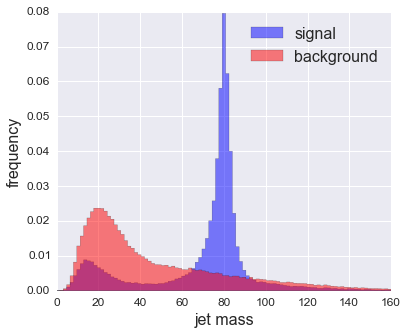

In [45]:
plot_dist_file('datasets/w_test.h5', var_name='mass', var_label="jet mass",
               bins=np.linspace(0, 160, 100),
               filename='plots/mass_dist.pdf')

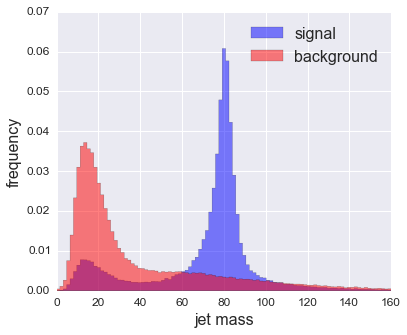

In [5]:
plot_dist_file('datasets/herwig_ang_test.h5', var_name='mass_trimmed_test',
               var_label="jet mass", bins=np.linspace(0, 160, 100))

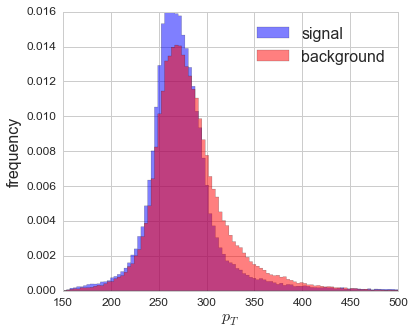

In [145]:
plot_dist_file('datasets/w_test.h5', var_name='pT', var_label=r"$p_T$",
               bins=np.linspace(150, 500, 100))

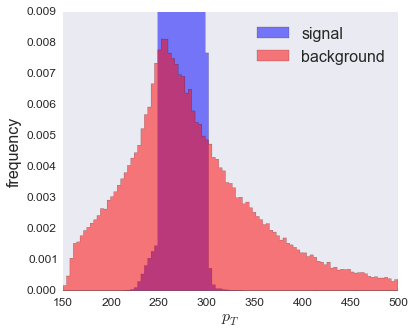

In [94]:
plot_dist_file('datasets/herwig_dip_test.h5', var_name='pt_trimmed_test', var_label=r"$p_T$",
               bins=np.linspace(150, 500, 100))

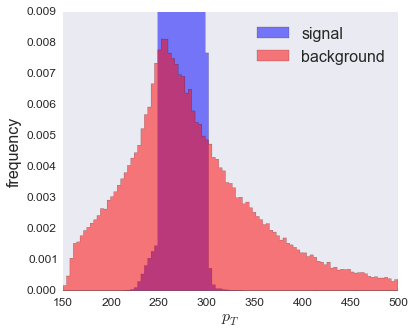

In [89]:
plot_dist_file('datasets/herwig_dip_test.h5', var_name='pt_trimmed_test', var_label=r"$p_T$",
               bins=np.linspace(150, 500, 100))

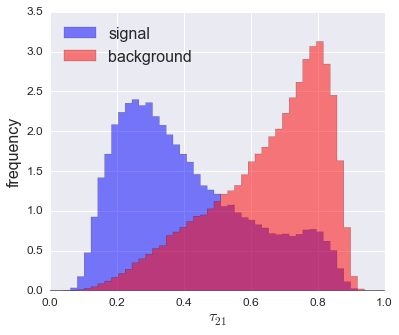

In [46]:
plot_dist_file('datasets/w_test.h5', var_name='tau_21', var_label=r"$\tau_{21}$",
               bins=np.linspace(0, 1, 50), loc=2, filename='plots/tau_dist.pdf')

In [9]:
Y_test_shrink, Y_prob_shrink = get_Y_prob(models.load_model('models/maxout_w_default'),
                                          'datasets/w_test.h5')

200000/200000 [==============================] - 34s    


In [51]:
Y_test_shrink_2, Y_prob_shrink_2 = get_Y_prob(models.load_model('models/maxout_w_default_2'),
                                              'datasets/w_test.h5')

200000/200000 [==============================] - 36s    


In [10]:
Y_test_noshrink, Y_prob_noshrink = get_Y_prob(models.load_model('models/maxout_w_noshrink'),
                                              'datasets/w_noshrink_test.h5')

200000/200000 [==============================] - 33s    


In [131]:
Y_test_ha, Y_prob_ha = get_Y_prob(models.load_model('models/maxout_w_default'),
                                  'datasets/herwig_ang_test_flat.h5')

99643/99643 [==============================] - 17s    


In [132]:
with h5py.File('datasets/herwig_ang_test_flat.h5') as h5file:
    weights_ha = h5file['weights'][:]

In [133]:
Y_test_hd, Y_prob_hd = get_Y_prob(models.load_model('models/maxout_w_default'),
                                  'datasets/herwig_dip_test_flat.h5')

126814/126814 [==============================] - 20s    


In [134]:
with h5py.File('datasets/herwig_dip_test_flat.h5') as h5file:
    weights_hd = h5file['weights'][:]

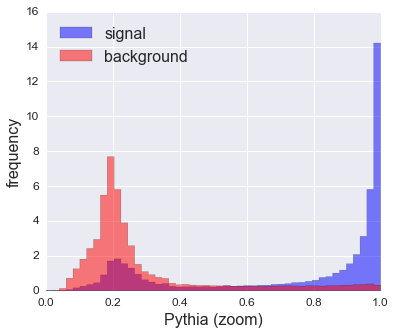

In [47]:
plot_dist(Y_test_shrink, Y_prob_shrink, var_label="Pythia (zoom)",
          bins=np.linspace(0, 1 , 50), loc=2, filename='plots/pythia_dist.pdf')

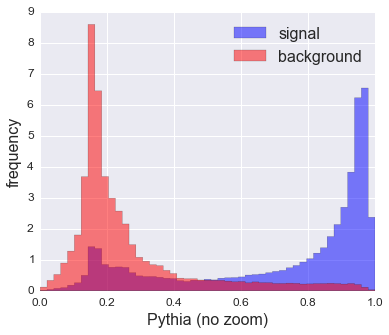

In [48]:
plot_dist(Y_test_noshrink, Y_prob_noshrink, var_label="Pythia (no zoom)",
          bins=np.linspace(0, 1 , 50), loc=1, filename='plots/pythia_noshrink_dist.pdf')

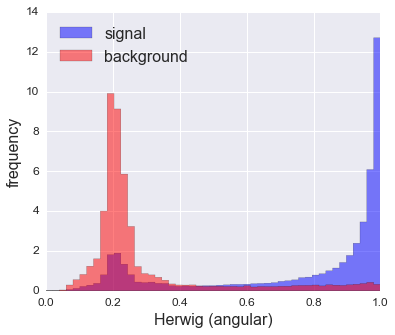

In [148]:
plot_dist(Y_test_ha, Y_prob_ha, var_label="Herwig (angular)",
          bins=np.linspace(0, 1 , 50), loc=2, filename='plots/herwig_ang_dist.pdf')

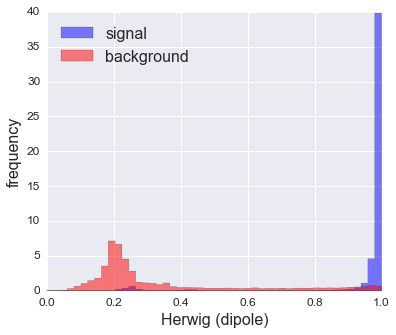

In [149]:
plot_dist(Y_test_hd, Y_prob_hd, var_label="Herwig (dipole)",
          bins=np.linspace(0, 1 , 50), loc=2, filename='plots/herwig_dip_dist.pdf')

In [166]:
roc_shrink = utils.default_roc_curve(Y_test_shrink, Y_prob_shrink)
roc_shrink_2 = utils.custom_roc_curve(Y_test_shrink_2, Y_prob_shrink_2)
roc_noshrink = utils.custom_roc_curve(Y_test_noshrink, Y_prob_noshrink)
roc_ha = utils.default_roc_curve(Y_test_ha, Y_prob_ha, weights_ha)
roc_hd = utils.default_roc_curve(Y_test_hd, Y_prob_hd, weights_hd)
roc_mass = utils.auxvar_roc_curve('datasets/w_test.h5', 'mass')
roc_tau_21 = utils.auxvar_roc_curve('datasets/w_test.h5', 'tau_21')

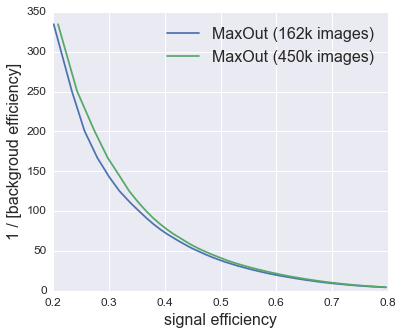

In [151]:
utils.plot_roc_curves([roc_shrink, roc_shrink_2],
                      ['MaxOut (162k images)', 'MaxOut (450k images)'],
                      filename='plots/train_roc_comp.pdf')

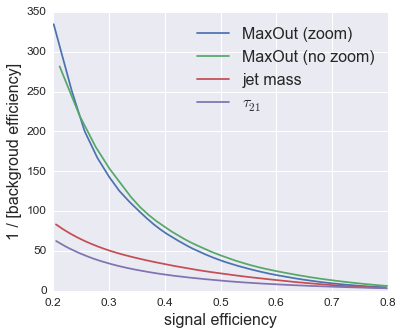

In [152]:
utils.plot_roc_curves([roc_shrink, roc_noshrink, roc_mass, roc_tau_21],
                      ['MaxOut (zoom)', 'MaxOut (no zoom)', 'jet mass', r'$\tau_{21}$'],
                      filename='plots/var_roc_comp.pdf')

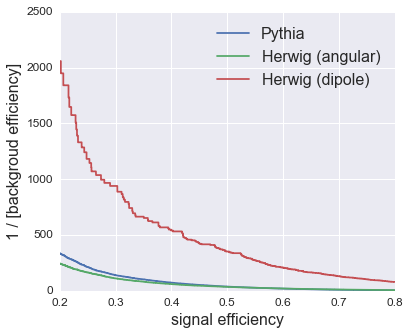

In [168]:
utils.plot_roc_curves([roc_shrink, roc_ha, roc_hd],
                      ['Pythia', 'Herwig (angular)', 'Herwig (dipole)'],
                     filename='plots/gen_roc_comp.pdf')

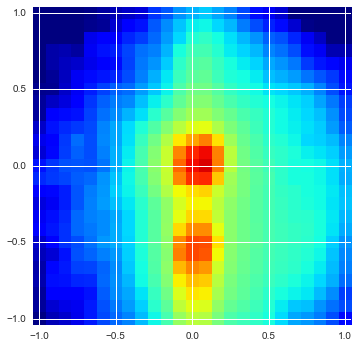

In [147]:
# plot jet images
with h5py.File('datasets/herwig_dip_test_flat.h5', 'r') as h5_input:
    images = h5_input['X_test'][:]
    images = images.reshape((-1, 25, 25))
seaborn.set_style('darkgrid')
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
avg_image = images.sum(axis=0) / len(images)
plot_jet_image_simple(ax, avg_image)
fig.tight_layout()
fig.show()
#fig.savefig('herwig_dip_image.png', format='png')